In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from scipy.stats import uniform

pd.set_option('display.float_format', '{:.5f}'.format)

In [2]:
# Load the dataset to see the first few rows and understand its structure
df = pd.read_csv('realtor-data.zip.csv')

In [3]:
df.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.00000,2.00000,0.12000,Adjuntas,Puerto Rico,601.00000,920.00000,NaN,105000.00000
1,for_sale,4.00000,2.00000,0.08000,Adjuntas,Puerto Rico,601.00000,1527.00000,NaN,80000.00000
2,for_sale,2.00000,1.00000,0.15000,Juana Diaz,Puerto Rico,795.00000,748.00000,NaN,67000.00000
3,for_sale,4.00000,2.00000,0.10000,Ponce,Puerto Rico,731.00000,1800.00000,NaN,145000.00000
4,for_sale,6.00000,2.00000,0.05000,Mayaguez,Puerto Rico,680.00000,NaN,NaN,65000.00000


#### Column Description

- **status**: Housing status - 
  - `a. ready for sale` or 
  - `b. ready to build`
- **bed**: Number of beds
- **bath**: Number of bathrooms
- **acre_lot**: Property / Land size in acres
- **city**: City name
- **state**: State name
- **zip_code**: Postal code of the area
- **house_size**: House area/size/living space in square feet
- **prev_sold_date**: Previously sold date
- **price**: Housing price, it is either the current listing price or recently sold price if the house is sold recently


## Exploratory data analysis

In [4]:
# Check for the number of rows and types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3520686 entries, 0 to 3520685
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   status          object 
 1   bed             float64
 2   bath            float64
 3   acre_lot        float64
 4   city            object 
 5   state           object 
 6   zip_code        float64
 7   house_size      float64
 8   prev_sold_date  object 
 9   price           float64
dtypes: float64(6), object(4)
memory usage: 268.6+ MB


In [5]:
# Descriptive Statistics for Numerical Columns
df.describe()

,bed,bath,acre_lot,zip_code,house_size,price
count,2838387.00000,2803588.00000,2801781.00000,3519994.00000,2472397.00000,3518956.00000
mean,3.35672,2.52180,21.43113,16808.52564,2147.53664,572206.32005
std,1.66825,1.57948,1031.65179,8569.61553,7183.14568,3549688.84272
min,1.00000,1.00000,0.00000,0.00000,4.00000,0.00000
25%,3.00000,2.00000,0.14000,10533.00000,1244.00000,160000.00000
50%,3.00000,2.00000,0.33000,16863.00000,1760.00000,325000.00000
75%,4.00000,3.00000,1.14000,22312.00000,2500.00000,595000.00000
max,210.00000,198.00000,100000.00000,99999.00000,9842382.00000,2147483647.00000


In [6]:
# Descriptive Statistics for Categorical Columns
cat_columns = df.select_dtypes(include=['object']).columns

{col: df[col].value_counts() for col in cat_columns}

{'status': for_sale          3470538
 ready_to_build      50148
 Name: status, dtype: int64,
 'city': Washington                         102029
 Pittsburgh                          67204
 New York City                       61299
 Philadelphia                        58059
 New York                            55544
                                     ...  
 Union Township                          1
 Premium                                 1
 Brittons Neck                           1
 Pratt                                   1
 100 89 Lower Shepard Creek Road         1
 Name: city, Length: 7683, dtype: int64,
 'state': New York                718602
 Pennsylvania            660206
 Maryland                297457
 Virginia                294575
 New Jersey              270514
 North Carolina          207332
 Massachusetts           177170
 Georgia                 157635
 West Virginia           141926
 South Carolina          127510
 Connecticut              98816
 District of Columbia   

In [7]:
df['zip_code'].value_counts()

20002.00000    10905
20009.00000    10182
20001.00000     9178
15601.00000     7635
25832.00000     7135
               ...  
15560.00000        1
29921.00000        1
28319.00000        1
25206.00000        1
4637.00000         1
Name: zip_code, Length: 9963, dtype: int64

In [8]:
# Check for misvalue_countsalues in each column
missing_values = df.isnull().sum()
missing_values

status                  0
bed                682299
bath               717098
acre_lot           718905
city                  473
state                   0
zip_code              692
house_size        1048289
prev_sold_date    1682153
price                1730
dtype: int64

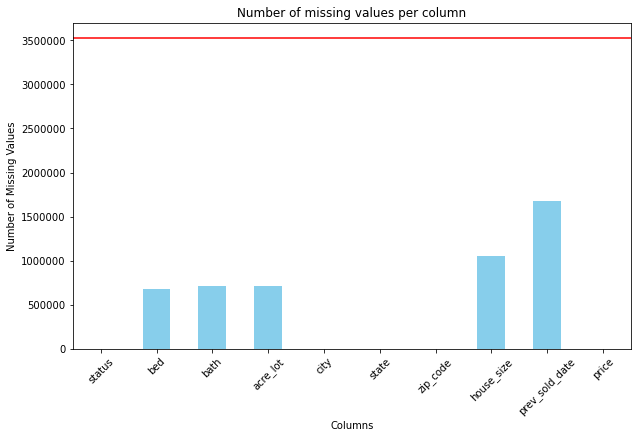

In [9]:
# Create a bar chart for the missing values
total_rows = len(df)

plt.figure(figsize=(10,6))
missing_values.plot(kind='bar', color='skyblue')
plt.axhline(y=total_rows, color='r', linestyle='-', label='Total Rows')
plt.title('Number of missing values per column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)  # Rotates the labels on the x-axis for better readability
plt.gca().ticklabel_format(style='plain', axis='y')
plt.show()

In [10]:
num_features = ['bed','bath','acre_lot','house_size','price']

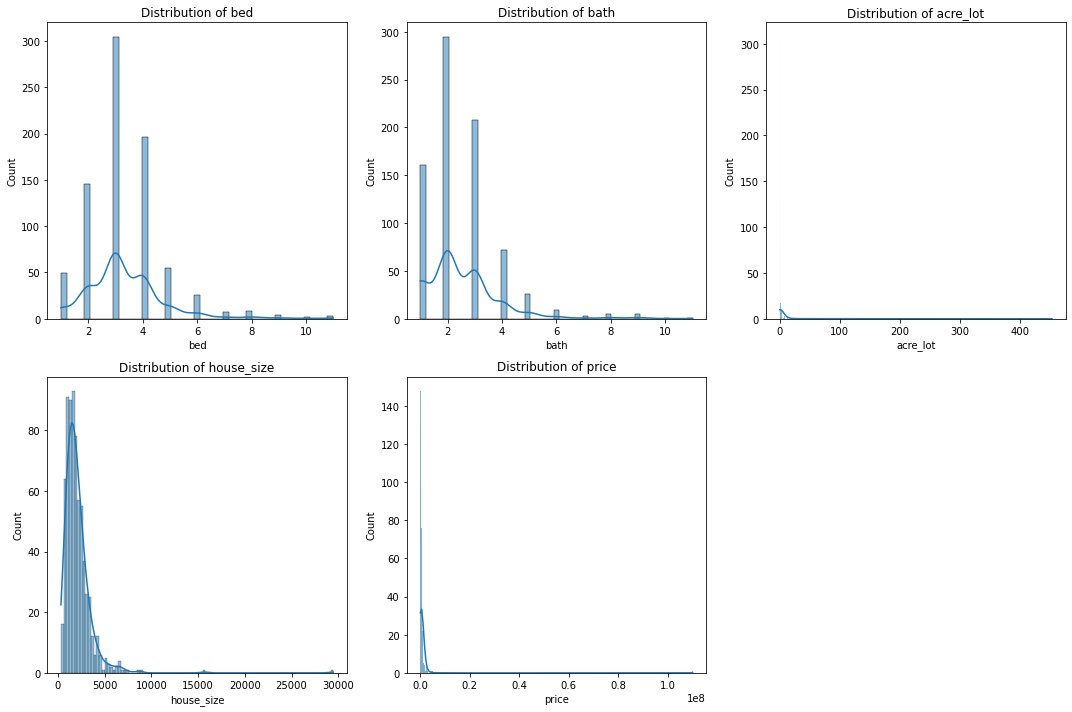

In [11]:
# Histograms for numerical features
num_features = ['bed','bath','acre_lot','house_size','price']

plt.figure(figsize=(15,10))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2,3,i)
    sns.histplot(df[feature].sample(1000), kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()

In [12]:
# Check how many values of acre_lot are egual to 0
len(df[df['acre_lot'] == 0])

5355

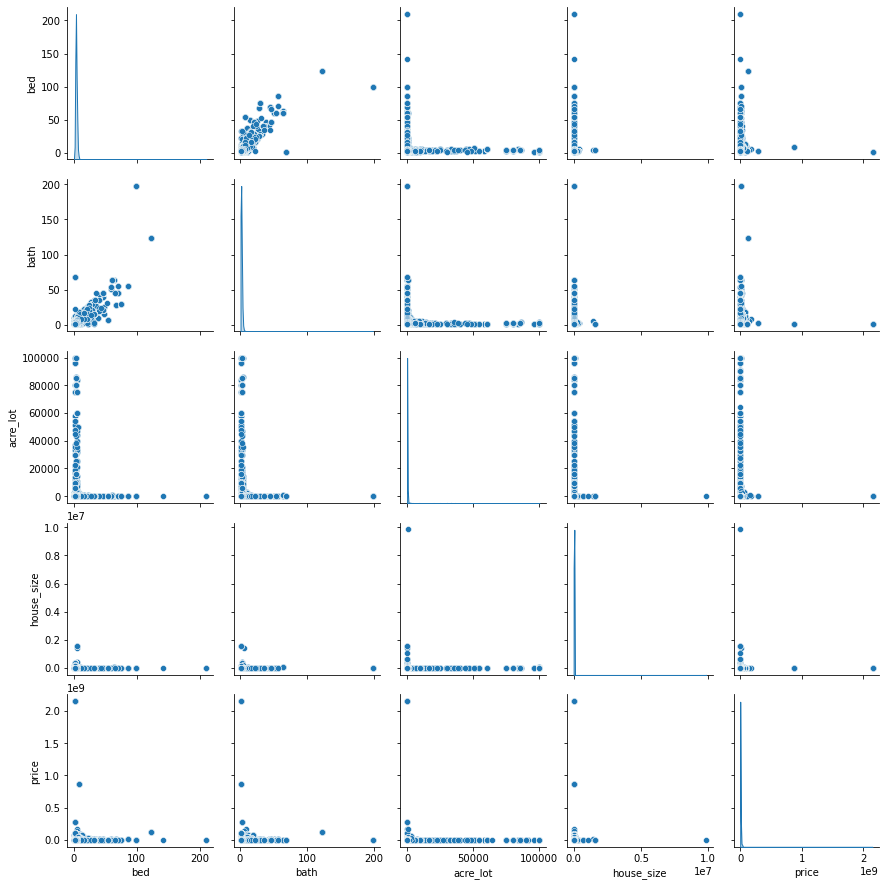

In [13]:
# Generate a pair plot to visualize the distributions and relationships between the numerical features: 'bed', 'bath', 'acre_lot', 'house_size', and 'price'.
sns.pairplot(df[['bed', 'bath', 'acre_lot', 'house_size', 'price']], diag_kind="kde")

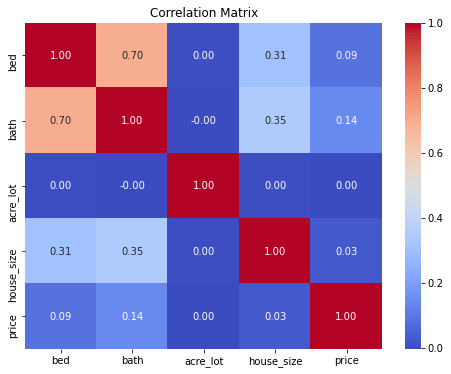

In [14]:
# Correlation Heatmap
num_features = ['bed','bath','acre_lot','house_size','price']

plt.figure(figsize=(8,6))
corr_matrix = df[num_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

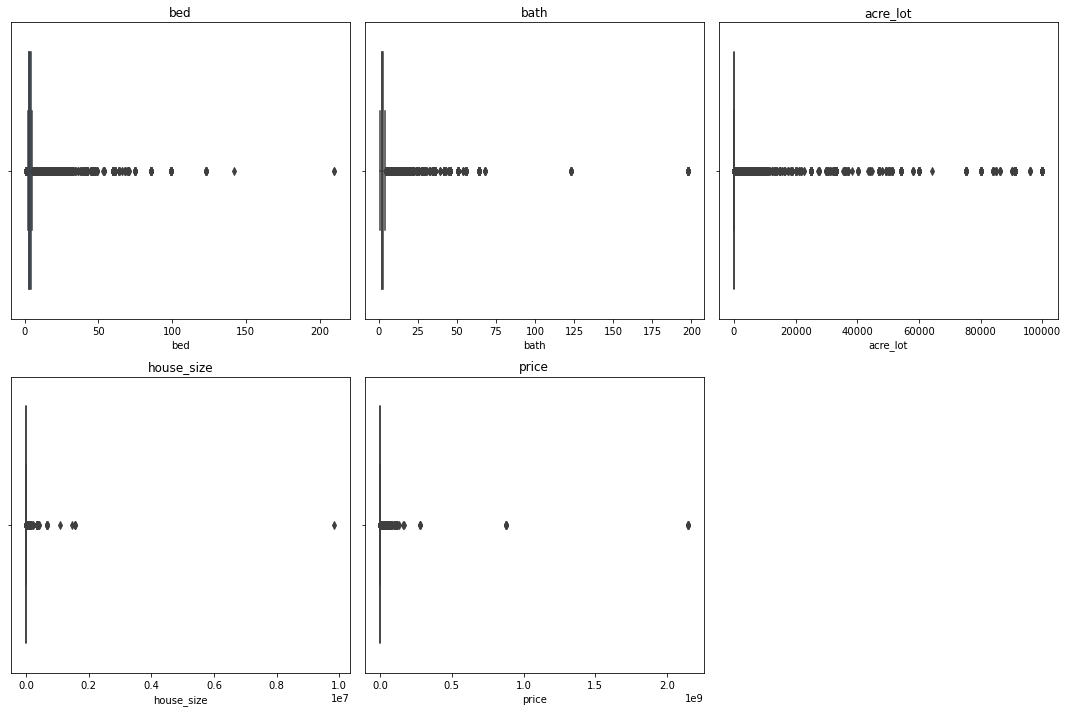

In [15]:
# Boxplots for numerical features - checking for outliers

plt.figure(figsize=(15,10))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2,3,i)
    sns.boxplot(x = df[feature])
    plt.title(f'{feature}')
plt.tight_layout()

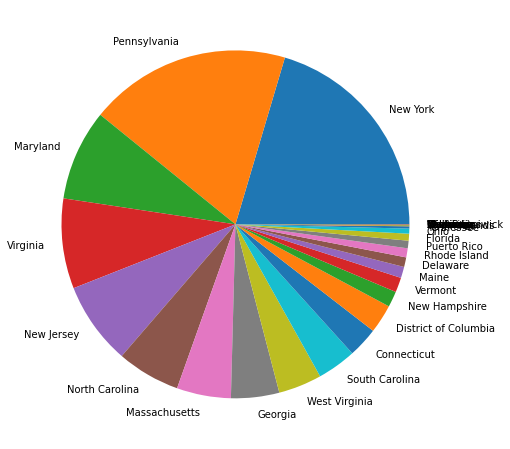

In [16]:
#where were the samples collected
ds_sample_counts = df.groupby('state').size().sort_values(ascending=False)

plt.figure(figsize=(10, 8))
plt.pie(data = ds_sample_counts, x= ds_sample_counts.values, labels = ds_sample_counts.index)
plt.show()

In [17]:
# Calculate the mean and standard deviation for 'acre_lot', 'house_size', and 'price' to extract Outliers
means = df[['bed','bath','acre_lot','house_size','price']].mean()
stds = df[['bed','bath','acre_lot','house_size','price']].std()

# Define outliers as those beyond 3 standard deviations from the mean
outliers = ((df[['bed','bath','acre_lot','house_size','price']] - means).abs() > 1.5 * stds).any(axis=1)

# Remove outliers
df_no_outliers_1 = df[~outliers]

# Check the shape of the dataframe before and after outlier removal
original_shape = df.shape[0]
new_shape = df_no_outliers_1.shape[0]
number = original_shape - new_shape

print (f'Number of outliers: {number}')

Number of outliers: 290398


## Preprocessing

In [18]:
# Remove outliers
means = df[['bed', 'bath', 'acre_lot', 'house_size', 'price']].mean()
stds = df[['bed', 'bath', 'acre_lot', 'house_size', 'price']].std()

# Define outliers as those beyond 3 standard deviations from the mean
outliers = ((df[['bed', 'bath', 'acre_lot', 'house_size', 'price']] - means).abs() > 2 * stds).any(axis=1)

# Remove outliers
df = df[~outliers]

len(df)

3379546

In [19]:
# Remove rows where 'city', 'zip_code' or price is missing
df = df.dropna(subset=['city', 'zip_code', 'price'])

In [20]:
# Impute missing values with the median for numeric columns
numeric_cols = ['bed', 'bath', 'acre_lot', 'house_size']
imputer = SimpleImputer(strategy='median')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

In [21]:
# Remove column prev_sold_date
df = df.drop('prev_sold_date', axis = 1)

In [22]:
# Input acre_lot 0's values with the value of house_size
df.loc[df['acre_lot'] == 0, 'acre_lot'] = df['house_size']

In [23]:
# Check for misvalue_countsalues in each column
missing_values = df.isnull().sum()
missing_values

status        0
bed           0
bath          0
acre_lot      0
city          0
state         0
zip_code      0
house_size    0
price         0
dtype: int64

In [24]:
# Feature Engineering
df['total_rooms'] = df['bed'] + df['bath']
df['large_house'] = (df['house_size'] > df['house_size'].median()).astype(int)
df['house_size_part_of_land_size'] = (df['house_size'] / df['acre_lot'] * 43560)

In [25]:
# Encoding categorical variables by using binary encoding
encoder = ce.BinaryEncoder(cols=['city', 'state'])

# Fit and transform the data
df = encoder.fit_transform(df)

In [26]:
# Convert 'status' into dummy variable
df = pd.get_dummies(df, columns=['status'], drop_first=True)

In [27]:
# Normalize numeric features
numeric_cols = ['bed', 'bath', 'acre_lot', 'house_size', 'total_rooms', 'house_size_part_of_land_size']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Check the new columns and the shape of the dataframe
df.shape, df.columns.tolist()

((3376870, 28),
 ['bed',
  'bath',
  'acre_lot',
  'city_0',
  'city_1',
  'city_2',
  'city_3',
  'city_4',
  'city_5',
  'city_6',
  'city_7',
  'city_8',
  'city_9',
  'city_10',
  'city_11',
  'city_12',
  'state_0',
  'state_1',
  'state_2',
  'state_3',
  'state_4',
  'zip_code',
  'house_size',
  'price',
  'total_rooms',
  'large_house',
  'house_size_part_of_land_size',
  'status_ready_to_build'])

In [28]:
# Grouping zip_codes based on residuals from different model - LINEAR REGRESSION

predictors = df.columns.tolist()
predictors.remove('zip_code')
predictors.remove('price')

outcome = 'price'

price_lm = LinearRegression()
price_lm.fit(df[predictors], df[outcome])


zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'zip_code': df['zip_code'],
        'residual' : df[outcome] - price_lm.predict(df[predictors]),
    })
    .groupby(['zip_code'])
    .apply(lambda x: {
        'zip_code': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['zip_group'] = pd.qcut(zip_groups['cum_count'], 10, labels=False, retbins=False)
zip_groups.head()
print(zip_groups.zip_group.value_counts().sort_index())

0    993
1    993
2    993
3    992
4    993
5    993
6    992
7    993
8    993
9    993
Name: zip_group, dtype: int64


In [29]:
to_join = zip_groups[['zip_code', 'zip_group']].set_index('zip_code')
df = df.join(to_join, on='zip_code')
df['zip_group'] = df['zip_group'].astype('category')

In [30]:
# Convert 'zip_group' into dummy variable
df = pd.get_dummies(df, columns=['zip_group'], drop_first=True)

## Split the data

In [31]:
# Splitting the dataframe into features (X) by dropping 'price' column and target variable (y) as 'price'
X = df.drop('price', axis = 1)
y = df['price']

In [32]:
# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)

## Choose and train a Model

In [33]:
def get_scores(true_y, pred_y, model_name, all_performances):
    all_performances['model_name'].append(model_name)
    all_performances['MAE'].append(mean_absolute_error(true_y, pred_y))
    all_performances['MSE'].append(mean_squared_error(true_y, pred_y))
    all_performances['R2-Score'].append(r2_score(true_y, pred_y))
    
all_performances = {'model_name':[],'MAE':[], 'MSE':[], 'R2-Score':[]}

In [34]:
# use training set only to get the median home prices for each zip code
training_data = pd.concat([X_train, y_train], axis = 1)
df_median_per_zipcode = training_data.groupby('zip_code', as_index=False)['price'].median()

median_home_price = training_data['price'].median()

df_base_line = X_test.merge(df_median_per_zipcode, on='zip_code', how='left')
df_base_line.loc[df_base_line['price'].isnull(), 'price'] = median_home_price

get_scores(y_test, df_base_line.price, 'Baseline using Median Values', all_performances)

In [35]:
# Remove column zip_code
df = df.drop('zip_code', axis = 1)

### Linear Regression

In [36]:
# Initialize the model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
get_scores(y_test, y_pred, 'Linear Regression', all_performances)

### Linear Regression with Regularizaton -> ElasticNet

In [37]:
# Initialize the model with cross validation and hyperparameters tuning
model = ElasticNetCV(cv=3, random_state=0, l1_ratio=[0.1, 0.5, 0.9], alphas=[0.1, 1, 10], max_iter=10000)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
get_scores(y_test, y_pred, 'ElasticNet', all_performances)

### Random Forest Regression

In [38]:
# Initialize the model
model = RandomForestRegressor(n_estimators=64, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
get_scores(y_test, y_pred, 'Random Forest', all_performances)

### GradientBoostingRegressor (XGBoost)

In [39]:
# Initialize the model
model = GradientBoostingRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
get_scores(y_test, y_pred, 'GradientBoostingRegressor', all_performances)

## Combining and presenting the results

In [40]:
df_performance = pd.DataFrame(all_performances)
df_performance

,model_name,MAE,MSE,R2-Score
0,Baseline using Median Values,208580.08558,212067183811.69150,0.37358
1,Linear Regression,210589.52636,175208634730.76965,0.48246
2,ElasticNet,213452.55409,180449309219.28760,0.46698
3,Random Forest,14908.14000,8561966547.78453,0.97471
4,GradientBoostingRegressor,180371.08598,132622047913.98444,0.60825


<ipython-input-41-72349a710d1d>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


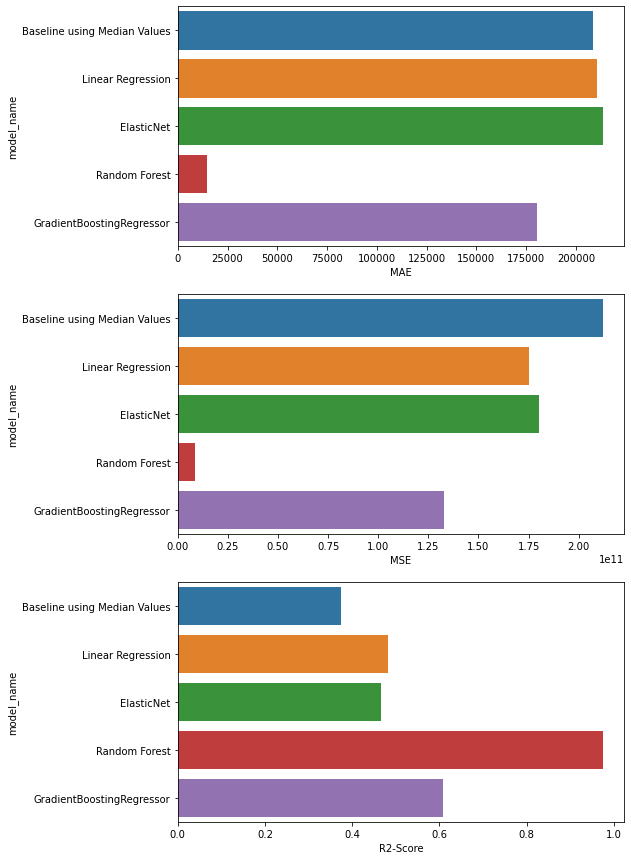

In [41]:
fig, axes = plt.subplots(3, 1, figsize = (8, 15))
sns.barplot(data = df_performance, y = 'model_name', x = 'MAE', ax = axes[0])

sns.barplot(data = df_performance, y = 'model_name', x = 'MSE', ax = axes[1])

sns.barplot(data = df_performance, y = 'model_name', x = 'R2-Score', ax = axes[2])

fig.show()